# Simulating retail transaction data with pyretailscience

In [1]:
from pyretailscience.data.simulation import Simulation

config_file = "../data/default_data_config.yaml"

sim = Simulation.from_config_file(seed=42, config_file=config_file)
sim.run()
sim.transactions[:2]

Simulating days: 100%|██████████| 729/729 [00:51<00:00, 14.15it/s]


[{'transaction_id': 18350,
  'transaction_datetime': datetime.datetime(2022, 1, 27, 17, 31, 29),
  'customer_id': 1,
  'product_id': 1002,
  'product_name': 'Roadie 24 Cooler',
  'category_0_name': 'Sports',
  'category_0_id': 6,
  'category_1_name': 'Water Sports',
  'category_1_id': 40,
  'brand_name': 'YETI',
  'brand_id': 201,
  'unit_price': 199.99,
  'quantity': 0,
  'total_price': 0.0,
  'store_id': 6},
 {'transaction_id': 18350,
  'transaction_datetime': datetime.datetime(2022, 1, 27, 17, 31, 29),
  'customer_id': 1,
  'product_id': 92,
  'product_name': 'Laugh & Learn Smart Stages Piggy Bank',
  'category_0_name': 'Toys',
  'category_0_id': 1,
  'category_1_name': 'Educational Toys',
  'category_1_id': 4,
  'brand_name': 'Fisher-Price',
  'brand_id': 19,
  'unit_price': 14.99,
  'quantity': 0,
  'total_price': 0.0,
  'store_id': 6}]

Now lets see that as a Pandas DataFrame

In [2]:
import pandas as pd

transactions_df = pd.DataFrame(sim.transactions)
transactions_df.head()

,transaction_id,transaction_datetime,customer_id,product_id,product_name,category_0_name,category_0_id,category_1_name,category_1_id,brand_name,brand_id,unit_price,quantity,total_price,store_id
0,18350,2022-01-27 17:31:29,1,1002,Roadie 24 Cooler,Sports,6,Water Sports,40,YETI,201,199.99,0,0.00,6
1,18350,2022-01-27 17:31:29,1,92,Laugh & Learn Smart Stages Piggy Bank,Toys,1,Educational Toys,4,Fisher-Price,19,14.99,0,0.00,6
2,18350,2022-01-27 17:31:29,1,1443,Mirthquake,Movies,9,Comedy,58,GiggleWorks,289,10.50,1,10.50,6
3,18350,2022-01-27 17:31:29,1,843,G-MAX Lawn Mower,Home,5,Gardening,34,Greenworks,169,299.99,1,299.99,6
4,18350,2022-01-27 17:31:29,1,859,Hue Go Portable Light,Home,5,Lighting,35,Philips Hue,172,79.99,6,479.94,6


Here we can see that work has been done to ensure that the category, brand and product names are realistic

In [3]:
transactions_df[["category_0_name", "category_0_id"]].drop_duplicates().sort_values("category_0_id")

,category_0_name,category_0_id
1,Toys,1
9,Grocery,2
20,Electronics,3
35,Clothing,4
3,Home,5
0,Sports,6
21,Beauty,7
7,Books,8
2,Movies,9
14,Music,10


And let's look at some of the characteristics of that dataset. For instance, the sales of toys by month

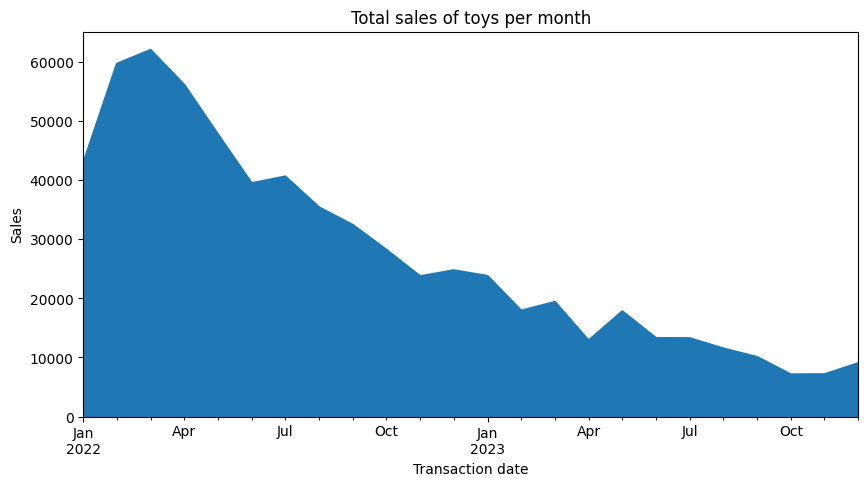

In [4]:
import matplotlib.pyplot as plt

toys_idx = transactions_df["category_0_name"] == "Toys"
ax = (
    transactions_df[toys_idx]
    .groupby(transactions_df[toys_idx]["transaction_datetime"].dt.to_period("M"))["total_price"]
    .sum()
    .plot.area(title="Total sales of toys per month", figsize=(10, 5))
)
ax.set_ylabel("Sales")
ax.set_xlabel("Transaction date")
plt.show()

Or let's see the distribution in number of days between customer orders

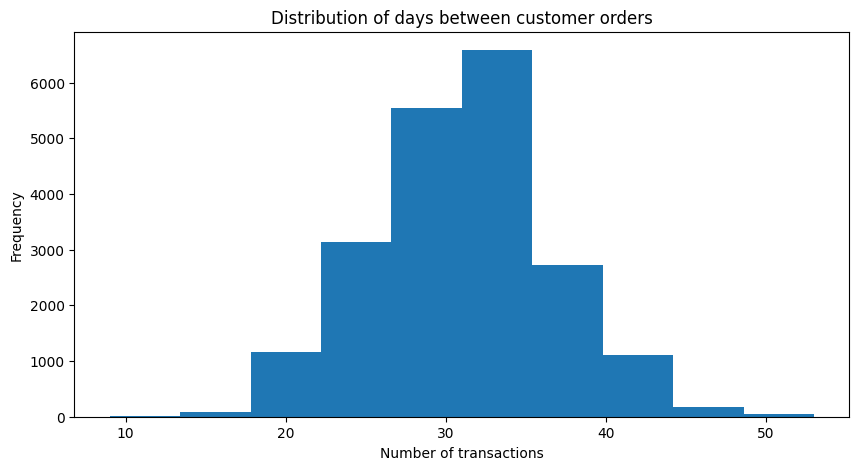

Mean days between orders: 30.9


In [5]:
days_between_df = transactions_df[["customer_id", "transaction_datetime"]].drop_duplicates()
days_between_df["transaction_datetime"] = days_between_df["transaction_datetime"].dt.date
days_between_df.sort_values(["customer_id", "transaction_datetime"], inplace=True)
days_between_s =  days_between_df.groupby("customer_id")["transaction_datetime"].diff().dropna().apply(lambda x: x.days)

ax = days_between_s.plot.hist(title="Distribution of days between customer orders", figsize=(10, 5))
ax.set_xlabel("Number of transactions")
plt.show()

print(f"Mean days between orders: {days_between_s.mean():.1f}")

## Simulating a different retailer

But let's say that you're trying to simulate data for a fashion retailer whose customers tend to shop once a quarter. Let's override the default settings in the config file 

First we'll take a peek inside the config file and see some of the settings you're likely to override

In [6]:
from pyretailscience.data.simulation import config_schema
import strictyaml as yaml
import pprint

with open(config_file, "r") as f:
        config = yaml.load(f.read(), config_schema).data

pprint.pprint({k: v for k, v in config.items() if k != 'products'}, indent=4)

{   'customers': {   'average_days_between_purchases': 30,
                     'average_new_customers_per_day': 5,
                     'churn_probability': 0.1,
                     'starting_number_of_customers': 2500},
    'stores': {'number_of_stores': 10},
    'transactions': {   'end_date': datetime.datetime(2023, 12, 31, 0, 0),
                        'end_hour': 20,
                        'max_products_per_transaction': 10,
                        'start_date': datetime.datetime(2022, 1, 1, 0, 0),
                        'start_hour': 7}}


Here you see that you can set the `average_days_between_purchases`. Let's increase the number this to 90 days and re-simulate the data

In [7]:
config["customers"]["average_days_between_purchases"] = 90

pprint.pprint({k: v for k, v in config.items() if k != 'products'}, indent=4)

{   'customers': {   'average_days_between_purchases': 90,
                     'average_new_customers_per_day': 5,
                     'churn_probability': 0.1,
                     'starting_number_of_customers': 2500},
    'stores': {'number_of_stores': 10},
    'transactions': {   'end_date': datetime.datetime(2023, 12, 31, 0, 0),
                        'end_hour': 20,
                        'max_products_per_transaction': 10,
                        'start_date': datetime.datetime(2022, 1, 1, 0, 0),
                        'start_hour': 7}}


Now let's resimulate the data with the new settings

In [8]:
sim = Simulation(seed=42, config=config)
sim.run()
sim.transactions[:2]

Simulating days: 100%|██████████| 729/729 [00:30<00:00, 23.71it/s]


[{'transaction_id': 8187,
  'transaction_datetime': datetime.datetime(2022, 3, 26, 17, 50, 54),
  'customer_id': 1,
  'product_id': 1537,
  'product_name': 'Fabled Forest',
  'category_0_name': 'Movies',
  'category_0_id': 9,
  'category_1_name': 'Animated',
  'category_1_id': 62,
  'brand_name': 'Dreamful Animations',
  'brand_id': 308,
  'unit_price': 16.5,
  'quantity': 0,
  'total_price': 0.0,
  'store_id': 5},
 {'transaction_id': 8187,
  'transaction_datetime': datetime.datetime(2022, 3, 26, 17, 50, 54),
  'customer_id': 1,
  'product_id': 535,
  'product_name': 'Pocket Tee',
  'category_0_name': 'Clothing',
  'category_0_id': 4,
  'category_1_name': 'T-Shirts',
  'category_1_id': 22,
  'brand_name': 'Supreme',
  'brand_id': 107,
  'unit_price': 59.99,
  'quantity': 0,
  'total_price': 0.0,
  'store_id': 5}]

Now let's redo our previous graph and see if it looks more like something you would see at a large retailer

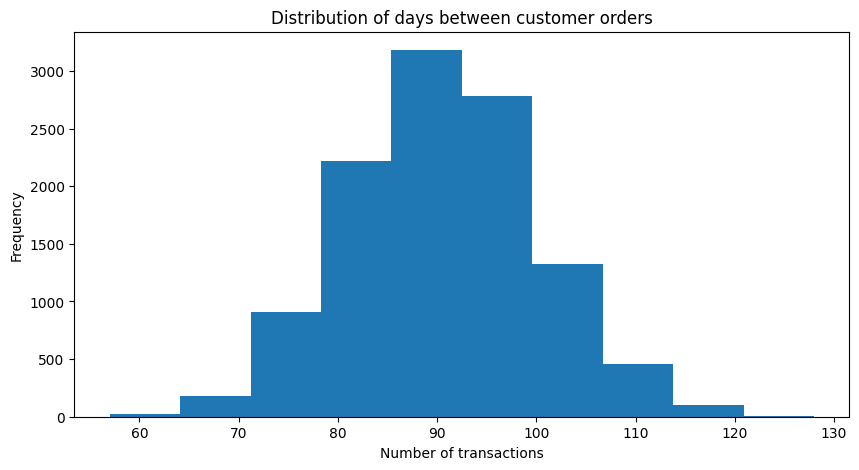

Mean days between orders: 90.7


In [9]:
transactions_df = pd.DataFrame(sim.transactions)

days_between_df = transactions_df[["customer_id", "transaction_datetime"]].drop_duplicates()
days_between_df["transaction_datetime"] = days_between_df["transaction_datetime"].dt.date
days_between_df.sort_values(["customer_id", "transaction_datetime"], inplace=True)
days_between_s =  days_between_df.groupby("customer_id")["transaction_datetime"].diff().dropna().apply(lambda x: x.days)

ax = days_between_s.plot.hist(title="Distribution of days between customer orders", figsize=(10, 5))
ax.set_xlabel("Number of transactions")
plt.show()

print(f"Mean days between orders: {days_between_s.mean():.1f}")